# Tesla Stock Price Prediction using Keras / Tensorflow and LSTM

By  Abhinav Sikhwal (GH1027622),


# Business Objective

This Deep Learning Pipeline is performed on the Tesla Stock Price Dataset.

The Dataset has been retrieved from Yahoo Finance - https://finance.yahoo.com/quote/TSLA/history/?period1=1561803090&period2=1719655882

The objective is to conduct a thorough analysis of the Dataset and Design a Machine Learning Model that can understand relationships between the features and make predictions on the stock price with Minimum Mean Squared Error and Maximum R2 Score.

# Problem Statement

The Data contains valuable Information about Different attributes of Tesla Stock with its closing Price for each day. As the Dataset contains very spefic information about the Opening price, volume, closing price and updated daily over a 5 years , it would be ideal to try LSTM netwrok for Time series data to make predictions.


# Importing the Necessary Libraries

In [1326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Reading the Dataset

In [1328]:
data = pd.read_csv('musk.csv') 

# Data Exploration

In [1330]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-07-01,15.347333,15.540000,15.085333,15.144667,15.144667,123201000
1,2019-07-02,15.259333,15.276667,14.814667,14.970000,14.970000,138885000
2,2019-07-03,15.959333,16.104668,15.634000,15.660000,15.660000,213016500
3,2019-07-05,15.638000,15.696667,15.386667,15.540000,15.540000,105985500
4,2019-07-08,15.416000,15.483333,15.244000,15.356000,15.356000,88207500


In [1331]:
data.shape

(1258, 7)

In [1332]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [1333]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,187.423552,191.590030,182.944866,187.360654,187.360654,1.285856e+08
std,96.098155,98.108000,93.782909,95.930817,95.930817,8.320808e+07
min,14.240000,14.334667,14.066667,14.093333,14.093333,2.940180e+07
25%,132.312000,136.340000,126.530003,133.467335,133.467335,7.783598e+07
50%,203.660004,208.220001,198.510002,203.351670,203.351670,1.045224e+08
75%,251.392498,256.570000,246.292503,251.844997,251.844997,1.481018e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [1334]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Dataset Information

This Dataset Contains Daily prices of the Tesla Stock over a period of 5 years. Each Row contains the Date, The Opening Price, the daily Low, The Daily High, The Closing price, the volume and the adjusted Closing price. 

The Minimum closing price of the stock is 14 dollars and the Maximum price is 409 dollars. The Average stock price over 5 years is 187 Dollars. 

The dataset contains no null values. 

Lets begin with Preprocessing the dataset. 



# Data Preprocessing

For the purpose of Processing and machine learning, the date Column will be transformed to date time format using pandas. 

Then we will select the relevant columns (In this case all of them) and scale the data between 0, 1 as required for machine learning. 

In [1337]:
# Converting the date column to datetime format for processing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [1338]:
# Selecting the relevant columns for the prediction
data = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

In [1339]:
# Normalizing the data for machine learning
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Splitting the Data

The dataset will be split using 80% for training and 20% for testing. 

In [1341]:
# Create training and testing datasets with a 80:20 ratio
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Creating Sequences from the Data

To create sequences from the data and adding the previous days price as the target for the present day we will use the Timeseries generator function in Tensorflow. This will automatically build the sequence as desired by machine learning. 

In [1343]:
# Specifying the time step and batch size to be used to create sequences
time_step = 10
batch_size = 64

In [1344]:
# Use TimeseriesGenerator to create sequences of the stock prices
train_generator = TimeseriesGenerator(train_data, train_data[:, 3], length=time_step, batch_size=batch_size)
test_generator = TimeseriesGenerator(test_data, test_data[:, 3], length=time_step, batch_size=batch_size)

# Hyperparameter Tunings

The Hyperparameters are specified below. However, many more combinations will be tried to achieve the best results. 

In [1346]:
# Specifying the Hyperparameters of the Model
lstm_units = 100
dropout_rate = 0.1
epochs = 30
learning_rate = 0.001

# Model Building

The Recurrent Neural Network LSTM model will be build using different combinations of LSTM layers and hyperparameters. 

In [1348]:
# Defining the RNN LSTM model
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(time_step, train_data.shape[1])))
model.add(Dropout(dropout_rate))
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(Dense(25))
model.add(Dense(1))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [1349]:
# Compiling the model with Adam optimizer
adam = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam, loss='mean_squared_error')

In [1350]:
# Printing the model summary
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                  │ (None, 10, 100)        │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 10, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10, 25)         │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10, 1)          │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,101 (918.36 KB)

 Trainable params: 235,101 (918.36 KB)

 Non-trainable params: 0 (0.00 B)

# Model Training

The Model Summary indicates that there are many more parameters that could be trained to achieve the best result. 

In [1351]:
# Training the LSTM model
history = model.fit(train_generator, epochs=epochs, validation_data=test_generator)

Epoch 1/30
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1923

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1710 - val_loss: 0.0701
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1117 - val_loss: 0.0352
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0577 - val_loss: 0.0403
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0428 - val_loss: 0.0178
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0329 - val_loss: 0.0138
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0410 - val_loss: 0.0108
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0328 - val_loss: 0.0143
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0228 - val_loss: 0.0093
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0220 - val_loss: 0.0099
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0253 - val_loss: 0.0077
Epoch 11/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0203 - val_loss: 0.0068
Epoch 12/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0183 - val_l

In [1352]:
# Printing the validation loss
print(f"Validation Loss: {history.history['val_loss'][-1]}")

Validation Loss: 0.0028869633097201586


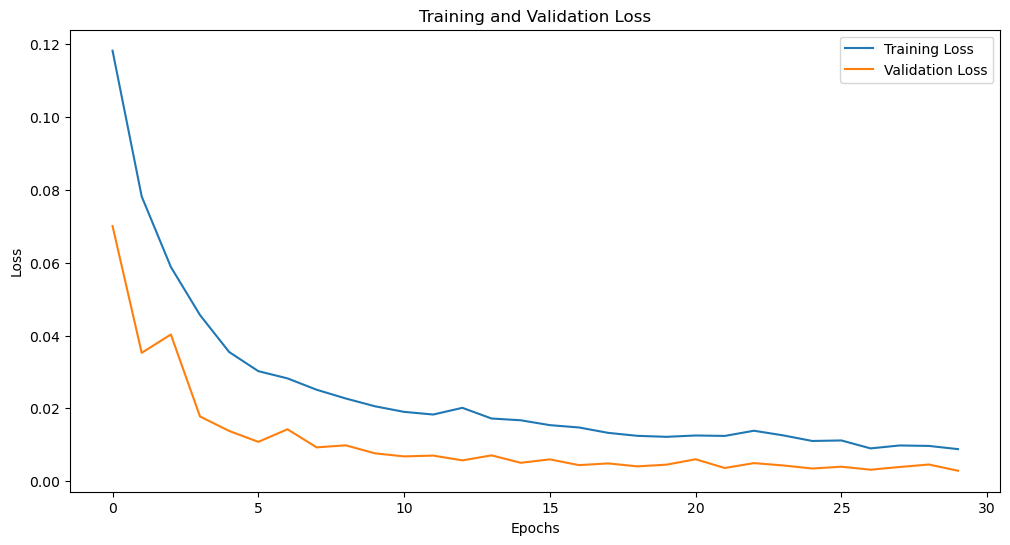

In [1353]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Making Predictions on the training set

In [1354]:
train_predict = model.predict(train_generator)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [1356]:
# Ensuring the Predictions match the actual values for better processing
y_train_actual = train_data[time_step:len(train_predict)+time_step, 3]

train_predict = train_predict[:, -1, 0] 
y_train_actual = y_train_actual[:len(train_predict)]

In [1361]:
# Calculating the MSE and R2 score for training set
mse_train = mean_squared_error(y_train_actual, train_predict)
r2_train = r2_score(y_train_actual, train_predict)

In [1362]:
print(f'Training MSE: {mse_train}')
print(f'Training R2 Score: {r2_train}')

Training MSE: 0.0011631482618107009
Training R2 Score: 0.9829990084044032


# Hyperparameters Experiments 

# Hyperparameter Tuning 1

Time Step : 60 
Batch Size : 128

lstm_units = 100
dropout_rate = 0.2
epochs = 30
learning_rate = 0.0001

LSTM Layers - 3

Training MSE: 0.0058
Training R2 Score: 0.9067



# Hyperparameter Tuning 2

Time Step : 60 
Batch Size : 128

lstm_units = 50
dropout_rate = 0.2
epochs = 30
learning_rate = 0.0001

LSTM Layers - 3

Training MSE: 0.0072
Training R2 Score: 0.8842

# Hyperparameter Tuning 3

Time Step : 30 
Batch Size : 128

lstm_units = 100
dropout_rate = 0.2
epochs = 50
learning_rate = 0.0001

LSTM Layers - 3

Training MSE: 0.0044
Training R2 Score: 0.9321

# Hyperparameter Tuning 4

Time Step : 30
Batch Size : 128

lstm_units = 100
dropout_rate = 0.2
epochs = 50
learning_rate = 0.0001

LSTM Layers - 4

Training MSE: 0.0066
Training R2 Score: 0.9001

# Hyperparameter Tuning 5

Time Step : 30
Batch Size : 128

lstm_units = 100
dropout_rate = 0.2
epochs = 50
learning_rate = 0.0001

LSTM Layers - 5

Training MSE: 0.0093
Training R2 Score: 0.8582

# Hyperparameter Tuning 6

Time Step : 10
Batch Size : 128

lstm_units = 100
dropout_rate = 0.2
epochs = 30
learning_rate = 0.0001

LSTM Layers - 6

Training MSE: 0.00777
Training R2 Score: 0.8864

# Hyperparameter Tuning 7

Time Step : 10
Batch Size : 128

lstm_units = 100
dropout_rate = 0.2
epochs = 50
learning_rate = 0.0001

LSTM Layers - 7 with one LSTM layer of 50 units

Training MSE: 0.0209
Training R2 Score: 0.6944

# Hyperparameter Tuning 8

Time Step : 10
Batch Size : 128

lstm_units = 100
dropout_rate = 0.2
epochs = 30
learning_rate = 0.0001

LSTM Layers - 3

Training MSE: 0.0133
Training R2 Score: 0.8047

# Hyperparameter Tuning 9

Time Step : 10
Batch Size : 64

lstm_units = 100
dropout_rate = 0.2
epochs = 30
learning_rate = 0.0001

LSTM Layers - 3

Training MSE: 0.00650
Training R2 Score: 0.9049

# Hyperparameter Tuning 10

Time Step : 10
Batch Size : 128

lstm_units = 100
dropout_rate = 0.1
epochs = 30
learning_rate = 0.0001

LSTM Layers - 3

Training MSE: 0.00555
Training R2 Score: 0.9187


# Hyperparameter Tuning 11

Time Step : 10
Batch Size : 128

lstm_units = 100
dropout_rate = 0.1
epochs = 30
learning_rate = 0.001

LSTM Layers - 3

Training MSE: 0.0024
Training R2 Score: 0.9637

# Hyperparameter Tuning 12

Time Step : 10
Batch Size : 128

lstm_units = 100
dropout_rate = 0.1
epochs = 30
learning_rate = 0.001

LSTM Layers - 4 with one layer of 50 Units

Training MSE: 0.0011
Training R2 Score: 0.9829


# Best Hyperparameters for Prediction 

As Visible above, after running all the different combination of Hyperparameter values we can conclude that the best model parameters for the stock price prediction is : 

Time Step : 10
Batch Size : 128

lstm_units = 100
dropout_rate = 0.1
epochs = 30
learning_rate = 0.001

LSTM Layers - 4 with one layer of 50 Units

This model returns the lowest Mean Squared Error and Maximum R2 Score. We will use this to make the predictions. 

# Making Predictions

Using the above Configuration, we will make prediction on the test set and evaluate the Actual / predicted prices. 

In [1377]:
# Making predictions for the stock price
test_predict = model.predict(test_generator)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [1378]:
y_test_actual = test_data[time_step:len(test_predict)+time_step, 3]

In [1379]:
test_predict = test_predict[:, -1, 0]  # Extract the last timestep and flatten
y_test_actual = y_test_actual[:len(test_predict)]

In [1382]:
# Calculating the MSE and R2 Score for test Set
mse = mean_squared_error(y_test_actual, test_predict)
r2 = r2_score(y_test_actual, test_predict)
print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MSE: 0.0006629424958934354
R2 Score: 0.9195167468018889


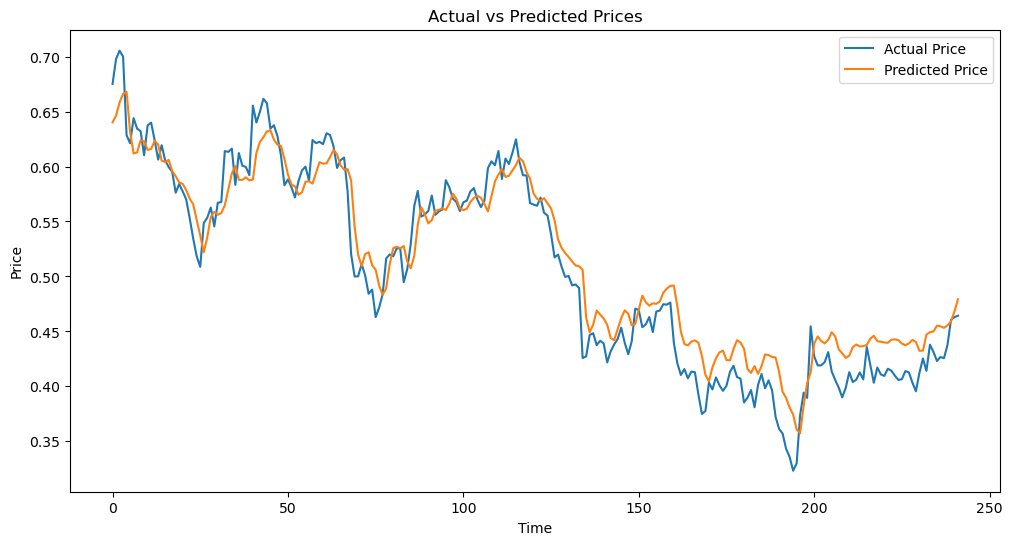

In [1383]:
# Plotting actual vs predicted prices to visualize
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Results & Recommendations

The Above Experiment results in a Mean Squared error of 0.0006 a Lower MSE value indicates a better accuracy and closer predictions to the actual prices of the tesla Stock. 

The R2 Score of 0.9195 indicates that approximately 91.95% of the variance in Tesla stock prices is explained by the model and that the model provides a good fit to the data, explaining a significant portion of the variability in the closing price of the stock.

In conclusion, an MSE of 0.0006629424958934354 and an R2 Score of 0.9195167468018889 suggests that the LSTM model for Tesla stock price prediction is performing well, with relatively low prediction errors and a strong ability to explain variability in stock prices based on the chosen features and model architecture.

The MSE and R2 score can be improved even further by Tuning Hyperparameters more and adding more layers to the LSTM Network. 